This Notebook shows how to optimise the pruning parameters of your network based on pairwise connectivity data.

First we need to create a small network that we can use for the optimisation of the pruning parameters.

In this example we do not need to have realistic neuron densities, so we will place the neurons in a cube of diameter 100 micrometers.

In [1]:
import os

n_neurons = 100
# pop_size = 10
# epochs = 10

pre_type = "iSPN"
post_type = "iSPN"
con_type = "GABA"

network_path = os.path.join("networks", f"{pre_type}_to_{post_type}")

SPN2SPNdistDepPruning = "1-exp(-(0.4*d/60e-6)**2)"
extra_pruning_parameters = { 'distPruning': SPN2SPNdistDepPruning }

all_experimental_data = {}
all_experimental_data["dSPN", "iSPN"] = [(0, 50e-6, 3/47.0), (0, 100e-6, 3/66.0)]
all_experimental_data["dSPN", "dSPN"] = [(0, 50e-6, 5/19.0), (0, 100e-6, 3/43.0)]
all_experimental_data["iSPN", "iSPN"] = [(0, 50e-6, 14/39.0), (0, 100e-6, 7/31.0)]
all_experimental_data["iSPN", "dSPN"] = [(0, 50e-6, 13/47.0), (0, 100e-6, 10/80.0)]

experimental_data = all_experimental_data[pre_type, post_type]
avg_num_synapses_per_pair = 3  # Expected mean, error weight

In [2]:
from snudda.place.create_cube_mesh import create_cube_mesh

mesh_file = os.path.join(network_path, "cube-mesh.obj")
create_cube_mesh(mesh_file, [0,0,0], 120e-6)

from snudda.init import SnuddaInit
si = SnuddaInit(network_path=network_path, random_seed=123, snudda_data="../../../../BasalGangliaData/data/")

si.define_structure(struct_name="Cube", struct_mesh=mesh_file, d_min=12e-6, mesh_bin_width=25e-6)

if pre_type == post_type:
    si.add_neurons(name=pre_type, num_neurons=n_neurons, volume_id="Cube",
                    neuron_dir=os.path.join("$DATA","neurons","striatum","dspn"))
else:
    si.add_neurons(name=pre_type, num_neurons=int(n_neurons/2), volume_id="Cube",
                    neuron_dir=os.path.join("$DATA","neurons","striatum","dspn"))
    si.add_neurons(name=post_type, num_neurons=int(n_neurons/2), volume_id="Cube",
                    neuron_dir=os.path.join("$DATA","neurons","striatum","dspn"))
    

# The parameters here does not matter, they will be set during optimisation
si.add_neuron_target(neuron_name=pre_type,
                     target_name=post_type,
                     connection_type=con_type,
                     dist_pruning=SPN2SPNdistDepPruning,
                     f1=None, soft_max=None, mu2=None,
                     a3=None,
                     conductance=[0.24e-9, 0.1e-9],
                     mod_file="tmGabaA")

si.write_json()

Adding neurons: iSPN from dir /home/hjorth/HBP/BasalGangliaData/data/neurons/striatum/dspn
Writing networks/iSPN_to_iSPN/network-config.json


In [3]:
from snudda import SnuddaPlace
sp = SnuddaPlace(network_path=network_path, verbose=False)
sp.place()

Reading SNUDDA_DATA=../../../../BasalGangliaData/data/ from networks/iSPN_to_iSPN/network-config.json


Reading SNUDDA_DATA=../../../../BasalGangliaData/data/ from networks/iSPN_to_iSPN/network-config.json


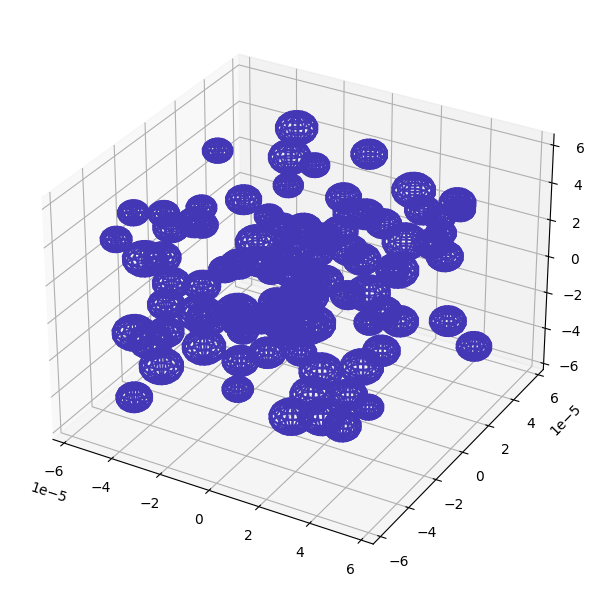

In [4]:
from snudda.plotting import PlotNetwork
network_file = os.path.join(network_path, "network-neuron-positions.hdf5")
pn = PlotNetwork(network_file)
pn.plot(plot_axon=False, plot_dendrite=False, plot_synapses=False)
pn.close() 

In [5]:
from snudda import SnuddaDetect

sd = SnuddaDetect(network_path=network_path, hyper_voxel_size=100)
sd.detect()

Reading SNUDDA_DATA=../../../../BasalGangliaData/data/ from networks/iSPN_to_iSPN/network-config.json
No d_view specified, running distribute neurons in serial
Processing hyper voxel : 31/125 (100 neurons)
Processing hyper voxel : 56/125 (100 neurons)
Processing hyper voxel : 32/125 (99 neurons)
Processing hyper voxel : 57/125 (97 neurons)
Processing hyper voxel : 36/125 (92 neurons)
Processing hyper voxel : 61/125 (90 neurons)
Processing hyper voxel : 37/125 (80 neurons)
Processing hyper voxel : 62/125 (66 neurons)
Processing hyper voxel : 26/125 (46 neurons)
Processing hyper voxel : 51/125 (43 neurons)
Processing hyper voxel : 30/125 (37 neurons)
Processing hyper voxel : 27/125 (30 neurons)
Processing hyper voxel : 55/125 (29 neurons)
Processing hyper voxel : 52/125 (26 neurons)
Processing hyper voxel : 6/125 (22 neurons)
Processing hyper voxel : 35/125 (21 neurons)
Processing hyper voxel : 60/125 (15 neurons)
Processing hyper voxel : 81/125 (13 neurons)
Processing hyper voxel : 11/1

In [6]:
from snudda.optimise.optimise_pruning import OptimisePruning
op = OptimisePruning(network_path=network_path)

In [7]:
op.merge_putative_synapses(force_merge=True)

Read 177639 out of total 177639 synapses


In [8]:
op.prune.connectivity_distributions

{(1,
  1,
  10): (OrderedDict([('f1', 1.0),
               ('softMax', None),
               ('mu2', None),
               ('a3', None),
               ('distPruning', '1-exp(-(0.4*d/60e-6)**2)'),
               ('cluster', False)]), None)}

In [9]:
op.prune.type_id_lookup

{'iSPN': 1}

In [10]:
op.prune.hist_file["meta/connectivityDistributions"][()]

b'{"iSPN$$iSPN": {"GABA": {"conductance": [2.4e-10, 1e-10], "channelParameters": {"modFile": "tmGabaA"}, "clusterSize": 1, "clusterSpread": null, "pruning": {"f1": null, "softMax": null, "mu2": null, "a3": null, "distPruning": "1-exp(-(0.4*d/60e-6)**2)", "cluster": false}, "channelModelID": 10, "lognormal_mu_sigma": [-22.230424900260093, 0.40010675493807013]}}}'

In [11]:
res = op.optimize(pre_type=pre_type, post_type=post_type, con_type=con_type, 
                  experimental_data=experimental_data, 
                  avg_num_synapses_per_pair=avg_num_synapses_per_pair,
                  extra_pruning_parameters=extra_pruning_parameters, 
                  workers=8, maxiter=100)

/home/hjorth/HBP/Snudda/venv/lib/python3.9/site-packages/scipy/optimize/_differentialevolution.py:377: UserWarning: differential_evolution: the 'workers' keyword has overridden updating='immediate' to updating='deferred'
  with DifferentialEvolutionSolver(func, bounds, args=args,


Worker iter: 50, fitness 10.753092503610013
Worker iter: 50, fitness 11.0770168101739
Worker iter: 50, fitness 11.047645774382122
Worker iter: 50, fitness 10.84878722159152
Worker iter: 50, fitness 11.118251530110205
Worker iter: 50, fitness 10.618534532386292
Worker iter: 50, fitness 10.782918477444705
Worker iter: 50, fitness 12.583697598383981
Worker iter: 100, fitness 10.584798789266543
Worker iter: 100, fitness 10.571017896210856
Worker iter: 100, fitness 10.379970857822203
Worker iter: 100, fitness 10.369370283546552
Worker iter: 100, fitness 10.475130078243977
Worker iter: 100, fitness 10.569147163903745
Worker iter: 100, fitness 10.055595027585056
Worker iter: 100, fitness 10.64575149730453
Worker iter: 150, fitness 10.369370283546552
Worker iter: 150, fitness 10.296970564280656
Worker iter: 150, fitness 10.266958087578098
Worker iter: 150, fitness 10.261163103553807
Worker iter: 150, fitness 10.245955722777913
Worker iter: 150, fitness 10.223994884067688
Worker iter: 150, fitn

In [12]:
res

     fun: 10.055595027585056
 message: 'Optimization terminated successfully.'
    nfev: 1625
     nit: 26
 success: True
       x: array([0.33701489, 3.61194187, 1.35621453, 0.60554513])

In [13]:
import os
from snudda.analyse.analyse import SnuddaAnalyse
import glob

# Get the last file
list_of_files = glob.glob(os.path.join(network_path, "temp", "network-synapses-*hdf5"))
network_file = max(list_of_files, key=os.path.getctime)

dist3D = False
y_max_H = None

sa = SnuddaAnalyse(network_file)

Assuming volume type: cube [cube or full]
Only using 20000 neurons of the connection data
Creating figures directory networks/iSPN_to_iSPN/temp/figures
Number of neurons: 100
Synapse row 0 - 0.0 % time: 0.0007375439963652752 seconds
Created connection matrix 0.009795450998353772 seconds
Created gap junction connection matrix 9.966699872165918e-05 seconds
Creating population dictionary
Done.
!!! Setting sideLen to None
Calculating synapse distance histogram
Creating dist histogram
n_synapses = 9248, at 0
Created distance histogram (optimised) in 0.00800148599955719 seconds
Saving cache to networks/iSPN_to_iSPN/temp/network-synapses-fcbfe528-0d4f-4b14-b51d-d916026c0bd3.hdf5-cache


Plotting connection probability iSPN to iSPN (synapses)
Centering in None : Keeping 100/100
Counting connections
Requested: 10000000.0 calculated [9900.]
P(d<5e-05) = 0.3509185115402732


/home/hjorth/HBP/Snudda/snudda/analyse/analyse.py:1380: RuntimeWarning: invalid value encountered in divide
  p_con = np.divide(count_con, count_all)


P(d<0.0001) = 0.3204629250307251


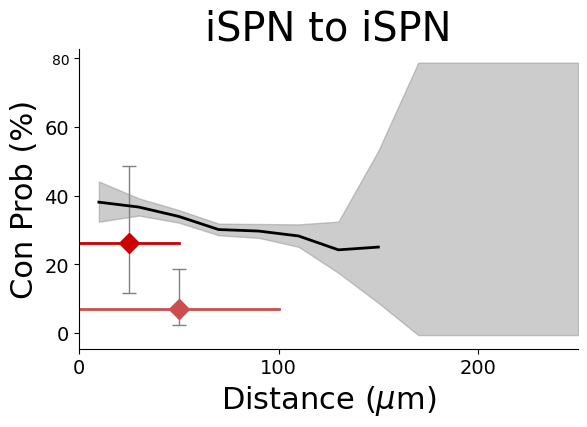

Wrote networks/iSPN_to_iSPN/temp/figures/Network-distance-dependent-connection-probability-iSPN-to-iSPN-synapses-3D-dist.pdf


({5e-05: 0.3509185115402732, 0.0001: 0.3204629250307251},
 'networks/iSPN_to_iSPN/temp/figures/Network-distance-dependent-connection-probability-iSPN-to-iSPN-synapses-3D-dist.pdf')

In [14]:
sa.plot_connection_probability("dSPN", "iSPN", dist_3d=True, exp_max_dist=[50e-6, 100e-6], exp_data_detailed=[(3, 47), (3, 66)])

In [ ]:
sa.plot_connection_probability("dSPN", "dSPN", dist_3d=True, exp_max_dist=[50e-6, 100e-6], exp_data_detailed=[(5, 19), (3, 43)])

In [ ]:
sa.plot_connection_probability("iSPN", "iSPN", dist_3d=True, exp_max_dist=[50e-6, 100e-6], exp_data_detailed=[(14, 39), (7, 31)])

In [ ]:
sa.plot_connection_probability("iSPN", "iSPN", dist_3d=True, exp_max_dist=[50e-6, 100e-6], exp_data_detailed=[(3, 47), (3, 66)])

In [ ]:
all_experimental_data["dSPN", "iSPN"] = [(0, 50e-6, 3/47.0), (0, 100e-6, 3/66.0)]
all_experimental_data["dSPN", "dSPN"] = [(0, 50e-6, 5/19.0), (0, 100e-6, 3/43.0)]
all_experimental_data["iSPN", "iSPN"] = [(0, 50e-6, 14/39.0), (0, 100e-6, 7/31.0)]
all_experimental_data["iSPN", "dSPN"] = [(0, 50e-6, 13/47.0), (0, 100e-6, 10/80.0)]